# DQN for continuous action space


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [6]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.821082861555377 -2.692583012889245
actions: 1 0
rewards: 1.0 1.0


In [8]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [9]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [11]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [12]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [13]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float64, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float64, [None], name='targetQs')
    return states, actions, targetQs

In [14]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [15]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [17]:
def model_loss(action_size, hidden_size, states, actions, targetQs):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels)
    Qs = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states) # nextQs
    targetQs = tf.reshape(targetQs, shape=[-1, 1])
    gloss = tf.reduce_mean(neg_log_prob_actions * targetQs) # DPG
    #dloss = tf.reduce_mean(tf.square(Qs - targetQs)) # DQN
    dloss = tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs,
                                                    labels=tf.nn.sigmoid(targetQs))
    dQs = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, reuse=True) # Qs
    dloss += tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs,
                                                     labels=tf.nn.sigmoid(targetQs))
    gloss1 = tf.reduce_mean(neg_log_prob_actions)
    gloss2 = tf.reduce_mean(Qs)
    gloss3 = tf.reduce_mean(dQs)
    gloss4 = tf.reduce_mean(targetQs)
    return actions_logits, Qs, gloss, dloss, gloss1, gloss2, gloss3, gloss4

In [18]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [19]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss, self.g_loss1, self.g_loss2, self.g_loss3, self.g_loss4 = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, targetQs=self.targetQs) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

In [20]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [21]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(1111, 4) actions:(1111,)
action size:2


In [22]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
action_size = 2
state_size = 4
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 200                # experience mini-batch size
gamma = 0.99                   # future reward discount

In [23]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [24]:
state = env.reset()
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    state = next_state
    if done is True:
        state = env.reset()

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [ ]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list, gloss_list, dloss_list = [], [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
    
    # Training episodes/epochs
    for ep in range(11111):
        total_reward = 0
        gloss_batch, dloss_batch = [], []
        gloss1_batch, gloss2_batch, gloss3_batch, gloss4_batch = [], [], [], []
        state = env.reset()

        # Training steps/batches
        for num_steps in range(1111111111):
            # Explore (Env) or Exploit (Model)
            total_step += 0.001
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            total_reward += reward
            state = next_state

            # Training
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            next_states = np.array([each[2] for each in batch])
            rewards = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            nextQs_logits = sess.run(model.Qs_logits, feed_dict = {model.states: next_states})
            #nextQs = np.max(nextQs_logits, axis=1) * (1-dones)
            nextQs = nextQs_logits.reshape([-1]) * (1-dones)
            targetQs = rewards + (gamma * nextQs)
            gloss, dloss, gloss1, gloss2, gloss3, gloss4, _, _ = sess.run([model.g_loss, model.d_loss,
                                                                           model.g_loss1, model.g_loss2, 
                                                                           model.g_loss3, model.g_loss4,
                                                                           model.g_opt, model.d_opt],
                                                                          feed_dict = {model.states: states, 
                                                                                       model.actions: actions,
                                                                                       model.targetQs: targetQs})
            gloss_batch.append(gloss)
            dloss_batch.append(dloss)
            gloss1_batch.append(gloss1)
            gloss2_batch.append(gloss2)
            gloss3_batch.append(gloss3)
            gloss4_batch.append(gloss4)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'Steps:{}'.format(num_steps),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'gloss:{:.4f}'.format(np.mean(gloss_batch)),
              'gloss1-lgP:{:.4f}'.format(np.mean(gloss1_batch)), #-logp
              'gloss2-gQs:{:.4f}'.format(np.mean(gloss2_batch)),#gQs
              'gloss3-dQs:{:.4f}'.format(np.mean(gloss3_batch)),#dQs
              'gloss4-tgtQ:{:.4f}'.format(np.mean(gloss4_batch)),#tgtQs
              'dloss:{:.4f}'.format(np.mean(dloss_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        gloss_list.append([ep, np.mean(gloss_batch)])
        dloss_list.append([ep, np.mean(dloss_batch)])
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.        
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 Steps:12 meanR:13.0000 R:13.0000 gloss:0.6837 gloss1-lgP:0.6970 gloss2-gQs:-0.0190 gloss3-dQs:0.0373 gloss4-tgtQ:0.9809 dloss:1.3832 exploreP:1.0000
Episode:1 Steps:22 meanR:18.0000 R:23.0000 gloss:0.7295 gloss1-lgP:0.6972 gloss2-gQs:0.0486 gloss3-dQs:0.1385 gloss4-tgtQ:1.0464 dloss:1.3446 exploreP:1.0000
Episode:2 Steps:19 meanR:18.6667 R:20.0000 gloss:0.7833 gloss1-lgP:0.6938 gloss2-gQs:0.1349 gloss3-dQs:0.2649 gloss4-tgtQ:1.1290 dloss:1.2956 exploreP:1.0000
Episode:3 Steps:13 meanR:17.5000 R:14.0000 gloss:0.8341 gloss1-lgP:0.6930 gloss2-gQs:0.2097 gloss3-dQs:0.3721 gloss4-tgtQ:1.2036 dloss:1.2529 exploreP:1.0000
Episode:4 Steps:20 meanR:18.2000 R:21.0000 gloss:0.8848 gloss1-lgP:0.6931 gloss2-gQs:0.2900 gloss3-dQs:0.4855 gloss4-tgtQ:1.2767 dloss:1.2087 exploreP:1.0000
Episode:5 Steps:24 meanR:19.3333 R:25.0000 gloss:0.9602 gloss1-lgP:0.6933 gloss2-gQs:0.4005 gloss3-dQs:0.6425 gloss4-tgtQ:1.3850 dloss:1.1468 exploreP:1.0000
Episode:6 Steps:20 meanR:19.5714 R:21.0000 gloss:1.

Episode:53 Steps:43 meanR:23.3889 R:44.0000 gloss:2.9147 gloss1-lgP:0.6921 gloss2-gQs:3.4126 gloss3-dQs:3.7677 gloss4-tgtQ:4.2115 dloss:0.2320 exploreP:0.9999
Episode:54 Steps:13 meanR:23.2182 R:14.0000 gloss:2.9532 gloss1-lgP:0.6931 gloss2-gQs:3.4428 gloss3-dQs:3.7754 gloss4-tgtQ:4.2609 dloss:0.2162 exploreP:0.9999
Episode:55 Steps:9 meanR:22.9821 R:10.0000 gloss:2.9555 gloss1-lgP:0.6918 gloss2-gQs:3.4611 gloss3-dQs:3.7921 gloss4-tgtQ:4.2720 dloss:0.2163 exploreP:0.9999
Episode:56 Steps:25 meanR:23.0351 R:26.0000 gloss:2.9744 gloss1-lgP:0.6928 gloss2-gQs:3.4915 gloss3-dQs:3.8157 gloss4-tgtQ:4.2934 dloss:0.2173 exploreP:0.9999
Episode:57 Steps:9 meanR:22.8103 R:10.0000 gloss:2.9843 gloss1-lgP:0.6926 gloss2-gQs:3.5124 gloss3-dQs:3.8281 gloss4-tgtQ:4.3087 dloss:0.2187 exploreP:0.9999
Episode:58 Steps:23 meanR:22.8305 R:24.0000 gloss:3.0122 gloss1-lgP:0.6925 gloss2-gQs:3.5377 gloss3-dQs:3.8409 gloss4-tgtQ:4.3495 dloss:0.2056 exploreP:0.9999
Episode:59 Steps:23 meanR:22.8500 R:24.0000 glos

Episode:105 Steps:14 meanR:23.2600 R:15.0000 gloss:3.6275 gloss1-lgP:0.6929 gloss2-gQs:4.5314 gloss3-dQs:4.4645 gloss4-tgtQ:5.2356 dloss:0.1591 exploreP:0.9998
Episode:106 Steps:23 meanR:23.2900 R:24.0000 gloss:3.6249 gloss1-lgP:0.6919 gloss2-gQs:4.5362 gloss3-dQs:4.4705 gloss4-tgtQ:5.2388 dloss:0.1602 exploreP:0.9998
Episode:107 Steps:49 meanR:23.5400 R:50.0000 gloss:3.6242 gloss1-lgP:0.6920 gloss2-gQs:4.5404 gloss3-dQs:4.4680 gloss4-tgtQ:5.2371 dloss:0.1613 exploreP:0.9998
Episode:108 Steps:8 meanR:23.3700 R:9.0000 gloss:3.5992 gloss1-lgP:0.6913 gloss2-gQs:4.5216 gloss3-dQs:4.4376 gloss4-tgtQ:5.2066 dloss:0.1697 exploreP:0.9998
Episode:109 Steps:18 meanR:23.2900 R:19.0000 gloss:3.6078 gloss1-lgP:0.6921 gloss2-gQs:4.5246 gloss3-dQs:4.4446 gloss4-tgtQ:5.2127 dloss:0.1670 exploreP:0.9997
Episode:110 Steps:25 meanR:23.3400 R:26.0000 gloss:3.6357 gloss1-lgP:0.6916 gloss2-gQs:4.5421 gloss3-dQs:4.4641 gloss4-tgtQ:5.2566 dloss:0.1566 exploreP:0.9997
Episode:111 Steps:14 meanR:23.3900 R:15.00

Episode:157 Steps:22 meanR:23.3000 R:23.0000 gloss:3.8756 gloss1-lgP:0.6907 gloss2-gQs:4.9234 gloss3-dQs:4.7709 gloss4-tgtQ:5.6112 dloss:0.1475 exploreP:0.9996
Episode:158 Steps:39 meanR:23.4600 R:40.0000 gloss:3.9223 gloss1-lgP:0.6919 gloss2-gQs:5.0006 gloss3-dQs:4.8386 gloss4-tgtQ:5.6686 dloss:0.1421 exploreP:0.9996
Episode:159 Steps:13 meanR:23.3600 R:14.0000 gloss:3.9108 gloss1-lgP:0.6920 gloss2-gQs:4.9604 gloss3-dQs:4.8144 gloss4-tgtQ:5.6512 dloss:0.1421 exploreP:0.9996
Episode:160 Steps:39 meanR:23.5900 R:40.0000 gloss:3.8409 gloss1-lgP:0.6925 gloss2-gQs:4.8846 gloss3-dQs:4.7217 gloss4-tgtQ:5.5462 dloss:0.1566 exploreP:0.9996
Episode:161 Steps:14 meanR:23.4900 R:15.0000 gloss:3.8689 gloss1-lgP:0.6926 gloss2-gQs:4.9004 gloss3-dQs:4.7394 gloss4-tgtQ:5.5864 dloss:0.1490 exploreP:0.9996
Episode:162 Steps:22 meanR:23.5700 R:23.0000 gloss:3.8784 gloss1-lgP:0.6930 gloss2-gQs:4.9352 gloss3-dQs:4.7664 gloss4-tgtQ:5.5969 dloss:0.1502 exploreP:0.9996
Episode:163 Steps:30 meanR:23.6600 R:31.

Episode:209 Steps:53 meanR:24.7300 R:54.0000 gloss:4.1617 gloss1-lgP:0.6925 gloss2-gQs:5.3781 gloss3-dQs:5.1958 gloss4-tgtQ:6.0102 dloss:0.1361 exploreP:0.9995
Episode:210 Steps:20 meanR:24.6800 R:21.0000 gloss:4.1935 gloss1-lgP:0.6925 gloss2-gQs:5.4144 gloss3-dQs:5.2477 gloss4-tgtQ:6.0560 dloss:0.1341 exploreP:0.9995
Episode:211 Steps:21 meanR:24.7500 R:22.0000 gloss:4.2422 gloss1-lgP:0.6923 gloss2-gQs:5.4841 gloss3-dQs:5.3258 gloss4-tgtQ:6.1275 dloss:0.1230 exploreP:0.9995
Episode:212 Steps:20 meanR:24.7900 R:21.0000 gloss:4.2201 gloss1-lgP:0.6921 gloss2-gQs:5.4789 gloss3-dQs:5.3131 gloss4-tgtQ:6.0978 dloss:0.1336 exploreP:0.9995
Episode:213 Steps:20 meanR:24.8000 R:21.0000 gloss:4.1992 gloss1-lgP:0.6917 gloss2-gQs:5.4197 gloss3-dQs:5.2418 gloss4-tgtQ:6.0710 dloss:0.1311 exploreP:0.9995
Episode:214 Steps:22 meanR:24.8200 R:23.0000 gloss:4.2510 gloss1-lgP:0.6922 gloss2-gQs:5.4924 gloss3-dQs:5.3308 gloss4-tgtQ:6.1418 dloss:0.1284 exploreP:0.9995
Episode:215 Steps:10 meanR:24.7100 R:11.

Episode:262 Steps:15 meanR:24.4300 R:16.0000 gloss:4.4527 gloss1-lgP:0.6915 gloss2-gQs:5.8580 gloss3-dQs:5.7047 gloss4-tgtQ:6.4392 dloss:0.1249 exploreP:0.9994
Episode:263 Steps:30 meanR:24.4300 R:31.0000 gloss:4.4978 gloss1-lgP:0.6918 gloss2-gQs:5.8986 gloss3-dQs:5.7517 gloss4-tgtQ:6.5014 dloss:0.1293 exploreP:0.9994
Episode:264 Steps:30 meanR:24.5000 R:31.0000 gloss:4.4402 gloss1-lgP:0.6915 gloss2-gQs:5.8346 gloss3-dQs:5.6710 gloss4-tgtQ:6.4213 dloss:0.1336 exploreP:0.9994
Episode:265 Steps:30 meanR:24.5800 R:31.0000 gloss:4.5045 gloss1-lgP:0.6923 gloss2-gQs:5.9037 gloss3-dQs:5.7477 gloss4-tgtQ:6.5064 dloss:0.1269 exploreP:0.9994
Episode:266 Steps:21 meanR:24.4000 R:22.0000 gloss:4.4783 gloss1-lgP:0.6917 gloss2-gQs:5.8875 gloss3-dQs:5.7230 gloss4-tgtQ:6.4747 dloss:0.1316 exploreP:0.9994
Episode:267 Steps:18 meanR:24.4300 R:19.0000 gloss:4.4940 gloss1-lgP:0.6922 gloss2-gQs:5.9138 gloss3-dQs:5.7628 gloss4-tgtQ:6.4925 dloss:0.1291 exploreP:0.9994
Episode:268 Steps:21 meanR:24.5300 R:22.

Episode:314 Steps:15 meanR:23.3000 R:16.0000 gloss:4.7121 gloss1-lgP:0.6918 gloss2-gQs:6.2686 gloss3-dQs:6.0981 gloss4-tgtQ:6.8111 dloss:0.1334 exploreP:0.9993
Episode:315 Steps:24 meanR:23.4400 R:25.0000 gloss:4.7678 gloss1-lgP:0.6920 gloss2-gQs:6.2999 gloss3-dQs:6.1290 gloss4-tgtQ:6.8895 dloss:0.1279 exploreP:0.9993
Episode:316 Steps:13 meanR:23.3700 R:14.0000 gloss:4.8301 gloss1-lgP:0.6917 gloss2-gQs:6.3816 gloss3-dQs:6.2234 gloss4-tgtQ:6.9831 dloss:0.1159 exploreP:0.9993
Episode:317 Steps:18 meanR:23.1400 R:19.0000 gloss:4.7046 gloss1-lgP:0.6916 gloss2-gQs:6.2516 gloss3-dQs:6.0897 gloss4-tgtQ:6.8025 dloss:0.1298 exploreP:0.9993
Episode:318 Steps:16 meanR:23.1000 R:17.0000 gloss:4.8034 gloss1-lgP:0.6916 gloss2-gQs:6.3578 gloss3-dQs:6.2001 gloss4-tgtQ:6.9451 dloss:0.1239 exploreP:0.9993
Episode:319 Steps:25 meanR:23.1000 R:26.0000 gloss:4.8198 gloss1-lgP:0.6910 gloss2-gQs:6.4079 gloss3-dQs:6.2662 gloss4-tgtQ:6.9752 dloss:0.1215 exploreP:0.9993
Episode:320 Steps:20 meanR:23.0000 R:21.

Episode:367 Steps:22 meanR:23.2600 R:23.0000 gloss:4.9305 gloss1-lgP:0.6917 gloss2-gQs:6.5919 gloss3-dQs:6.4102 gloss4-tgtQ:7.1284 dloss:0.1240 exploreP:0.9991
Episode:368 Steps:21 meanR:23.2600 R:22.0000 gloss:4.9852 gloss1-lgP:0.6922 gloss2-gQs:6.6741 gloss3-dQs:6.5163 gloss4-tgtQ:7.2023 dloss:0.1242 exploreP:0.9991
Episode:369 Steps:11 meanR:23.2300 R:12.0000 gloss:4.9955 gloss1-lgP:0.6929 gloss2-gQs:6.6503 gloss3-dQs:6.4736 gloss4-tgtQ:7.2094 dloss:0.1180 exploreP:0.9991
Episode:370 Steps:8 meanR:23.0500 R:9.0000 gloss:4.9784 gloss1-lgP:0.6910 gloss2-gQs:6.6775 gloss3-dQs:6.5031 gloss4-tgtQ:7.2044 dloss:0.1266 exploreP:0.9991
Episode:371 Steps:21 meanR:23.1400 R:22.0000 gloss:5.0702 gloss1-lgP:0.6919 gloss2-gQs:6.7776 gloss3-dQs:6.6168 gloss4-tgtQ:7.3278 dloss:0.1111 exploreP:0.9991
Episode:372 Steps:11 meanR:22.9600 R:12.0000 gloss:4.9082 gloss1-lgP:0.6901 gloss2-gQs:6.5796 gloss3-dQs:6.4054 gloss4-tgtQ:7.1126 dloss:0.1333 exploreP:0.9991
Episode:373 Steps:17 meanR:23.0500 R:18.00

Episode:420 Steps:17 meanR:24.5300 R:18.0000 gloss:5.1332 gloss1-lgP:0.6921 gloss2-gQs:6.8929 gloss3-dQs:6.7160 gloss4-tgtQ:7.4169 dloss:0.1241 exploreP:0.9990
Episode:421 Steps:37 meanR:24.7300 R:38.0000 gloss:5.1173 gloss1-lgP:0.6916 gloss2-gQs:6.8691 gloss3-dQs:6.6851 gloss4-tgtQ:7.3993 dloss:0.1194 exploreP:0.9990
Episode:422 Steps:18 meanR:24.7300 R:19.0000 gloss:5.1411 gloss1-lgP:0.6911 gloss2-gQs:6.8842 gloss3-dQs:6.7128 gloss4-tgtQ:7.4388 dloss:0.1127 exploreP:0.9990
Episode:423 Steps:10 meanR:24.6500 R:11.0000 gloss:5.0902 gloss1-lgP:0.6904 gloss2-gQs:6.8449 gloss3-dQs:6.6489 gloss4-tgtQ:7.3725 dloss:0.1171 exploreP:0.9990
Episode:424 Steps:12 meanR:24.3000 R:13.0000 gloss:5.1465 gloss1-lgP:0.6904 gloss2-gQs:6.9235 gloss3-dQs:6.7467 gloss4-tgtQ:7.4548 dloss:0.1162 exploreP:0.9990
Episode:425 Steps:54 meanR:24.4500 R:55.0000 gloss:5.1353 gloss1-lgP:0.6909 gloss2-gQs:6.8929 gloss3-dQs:6.7192 gloss4-tgtQ:7.4327 dloss:0.1176 exploreP:0.9990
Episode:426 Steps:13 meanR:24.4700 R:14.

Episode:472 Steps:13 meanR:25.2500 R:14.0000 gloss:5.2853 gloss1-lgP:0.6914 gloss2-gQs:7.1332 gloss3-dQs:6.9478 gloss4-tgtQ:7.6446 dloss:0.1136 exploreP:0.9989
Episode:473 Steps:26 meanR:25.3400 R:27.0000 gloss:5.2387 gloss1-lgP:0.6920 gloss2-gQs:7.0517 gloss3-dQs:6.8690 gloss4-tgtQ:7.5708 dloss:0.1207 exploreP:0.9989
Episode:474 Steps:47 meanR:25.6000 R:48.0000 gloss:5.2742 gloss1-lgP:0.6907 gloss2-gQs:7.1038 gloss3-dQs:6.9258 gloss4-tgtQ:7.6366 dloss:0.1171 exploreP:0.9989
Episode:475 Steps:14 meanR:25.4800 R:15.0000 gloss:5.3029 gloss1-lgP:0.6921 gloss2-gQs:7.1693 gloss3-dQs:6.9550 gloss4-tgtQ:7.6616 dloss:0.1139 exploreP:0.9989
Episode:476 Steps:10 meanR:25.3400 R:11.0000 gloss:5.2939 gloss1-lgP:0.6914 gloss2-gQs:7.1405 gloss3-dQs:6.9360 gloss4-tgtQ:7.6569 dloss:0.1122 exploreP:0.9989
Episode:477 Steps:38 meanR:25.5900 R:39.0000 gloss:5.2965 gloss1-lgP:0.6905 gloss2-gQs:7.1467 gloss3-dQs:6.9385 gloss4-tgtQ:7.6702 dloss:0.1177 exploreP:0.9989
Episode:478 Steps:13 meanR:25.6000 R:14.

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [86]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

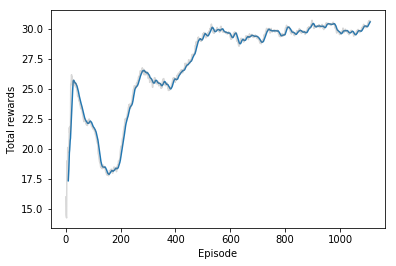

In [87]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

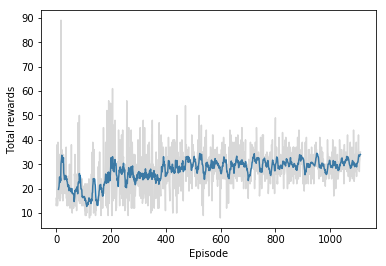

In [88]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'G losses')

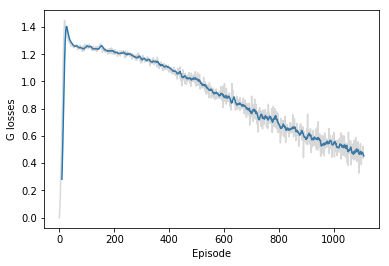

In [89]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0, 0.5, 'D losses')

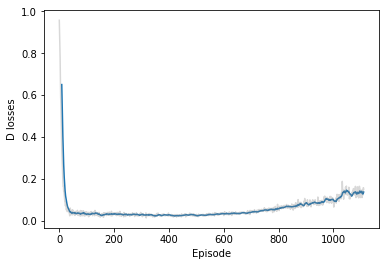

In [90]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [36]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.